# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

In [1]:
print("hello world!")

hello world!


## Imports entire notebook

In [2]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")


# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.notebook import tqdm
import os
import shutil
import subprocess
import zipfile
import re
import random

Running in Google Colab


## Global Definitions

In [3]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [4]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


In [5]:
# If we are in colab and we need to mount the drive
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")
  data_path = f"/content/drive/MyDrive/{data_path}"
else:
  print("Not in Google Colab.")

Mounted at /content/drive
Google Drive mounted successfully.


# Load Data

In [6]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print("First 10 rows of Xtrain:")
print(Xtrain[:10])

# Scale
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)

# Convert to a PyTorch tensor if needed
Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32, device=device)
print("Xtrain as a PyTorch tensor:", Xtrain_tensor.shape)

Shape of Xtrain: (1000, 1)
First 10 rows of Xtrain:
[[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]
 [ 21]
 [ 32]
 [ 72]
 [138]
 [111]]
Xtrain as a PyTorch tensor: torch.Size([1000, 1])


# Generate plot of data

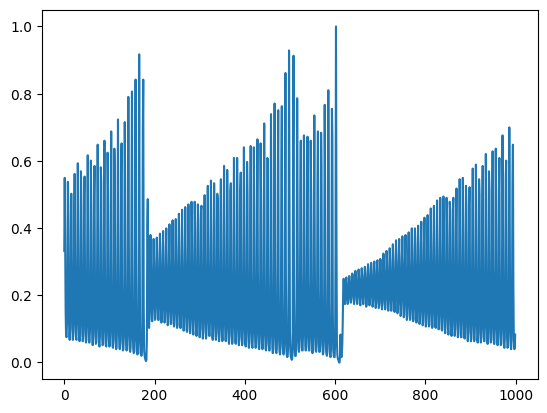

In [7]:
plt.plot(Xtrain)

# Divide data into training and test

In [8]:
trainingInputs = Xtrain_tensor[:800]
trainingExpectedOutputs = Xtrain_tensor[1:801]
testingInputs = Xtrain_tensor[800:999]
testingExpectedOutputs = Xtrain_tensor[801:]
print("Training shape: ", trainingInputs.shape, ". Testing shape", testingInputs.shape)
#print("Actual shape try", Xtrain_tensor[0:800])

Training shape:  torch.Size([800, 1]) . Testing shape torch.Size([199, 1])


# Helper functions

In [105]:
def create_sequences(data, window_size):
    # Split data into subsets using sliding window

    # Return: X, the sequences, and y, the target number for that sequence
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

    #return np.array(X), np.array(y)

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y

sequences2, input2 = create_sequences(trainingInputs.cpu(), 200)

print(sequences2.shape)

torch.Size([600, 200, 1])


# Model & Hyperparameters

In [106]:
input_size = 1
hidden_size = 128
sequence_length = 800
num_layers = 1
dropout_prob = 0.0
#window_size = 200
window_size = 50

learning_rate = 0.001

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):#, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_prob)

        # With normal activation function (non-linearity), tanh, the loss function decreased slower.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='relu', batch_first = True)

        # input: tensor of shape (batch_size, sequence length, input size)

        # End with one fully connected layer from hidden to 1 number
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device) # <- hier zit en error, ik snap niet hoe, misschien hoe x ge input is?

        out, _ = self.rnn(x, h0)

        # out: tensor of shape (batch_size, sequence_length, hidden_size), select last
        out = out[:,-1,:]

        # out: (batch size, 128)

        out = self.dropout(out)

        # out (800, 128)

        # in the tutorial, the guy takes only the final number, like this:
        # out = out[-1,:]

        # run this through the final layer to get scalar?
        out = self.fc(out)
        return out



model = RNN(input_size, hidden_size, num_layers).to(device)
#model = torch.nn.RNN(input_size, hidden_size, num_layers).to(device)

# Loss function (maybe add optimizer?)

In [107]:
criterion = nn.MSELoss() # In the tutorial, crossentropyloss is used instead
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # We have to explain why we use adam

# Train the model

In [108]:
num_epochs = 100
sequences, targets = create_sequences(trainingInputs.cpu(), window_size)
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)

model.train() # sets model to training mode (reactivates dropout layer)

for epoch in range(num_epochs):
  sequences = sequences.to(device)
  targets = targets.to(device)

  # Forward pass
  output = model(sequences)

  loss = criterion(output, targets)

  # Backpropagate
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Print loss
  print("Epoch: ", epoch, ", loss:", loss.item())

"""for epoch in range(num_epochs):
  for i in range(sequences.shape[0]):
    input_seq = torch.tensor(sequences[i], dtype=torch.float32).unsqueeze(1).to(device)  # shape: [seq_len, 1, 1]
    target = torch.tensor(targets[i], dtype=torch.float32).to(device)  # shape: [1]

    # Forward pass
    output = model(input_seq)

    loss = criterion(output, target)

    # Backpropagate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Print loss
  print("Epoch: ", epoch, ", loss:", loss.item())

"""

Sequences shape: torch.Size([750, 50, 1])
Targets shape: torch.Size([750, 1])
Epoch:  0 , loss: 0.09171958267688751
Epoch:  1 , loss: 0.07821353524923325
Epoch:  2 , loss: 0.06624285131692886
Epoch:  3 , loss: 0.05567546933889389
Epoch:  4 , loss: 0.04675287753343582
Epoch:  5 , loss: 0.0399811752140522
Epoch:  6 , loss: 0.03587639704346657
Epoch:  7 , loss: 0.035583458840847015
Epoch:  8 , loss: 0.039101000875234604
Epoch:  9 , loss: 0.04196320101618767
Epoch:  10 , loss: 0.04163328930735588
Epoch:  11 , loss: 0.039378900080919266
Epoch:  12 , loss: 0.036919005215168
Epoch:  13 , loss: 0.0351727232336998
Epoch:  14 , loss: 0.0342843160033226
Epoch:  15 , loss: 0.03401251137256622
Epoch:  16 , loss: 0.034085169434547424
Epoch:  17 , loss: 0.034280553460121155
Epoch:  18 , loss: 0.03446738049387932
Epoch:  19 , loss: 0.03456953912973404
Epoch:  20 , loss: 0.03454474359750748
Epoch:  21 , loss: 0.03440475836396217
Epoch:  22 , loss: 0.03414535894989967
Epoch:  23 , loss: 0.03380830585956

'for epoch in range(num_epochs):\n  for i in range(sequences.shape[0]):\n    input_seq = torch.tensor(sequences[i], dtype=torch.float32).unsqueeze(1).to(device)  # shape: [seq_len, 1, 1]\n    target = torch.tensor(targets[i], dtype=torch.float32).to(device)  # shape: [1]\n\n    # Forward pass\n    output = model(input_seq)\n\n    loss = criterion(output, target)\n\n    # Backpropagate\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n\n  # Print loss\n  print("Epoch: ", epoch, ", loss:", loss.item())\n\n'

#Model test (new)



In [109]:
model.eval() # sets model to eval mode (no dropout layer)

preds = []

startingInput = Xtrain_tensor[800-window_size:800].unsqueeze(0)
print(startingInput.shape)

for i in range(200):
  with torch.no_grad():

    pred = model(startingInput)
    preds.append(pred.item())
    #print(startingInput[:, -3:])
    startingInput = torch.cat((startingInput[:, 1:], pred.unsqueeze(0)), 1)
    print(pred.item())



torch.Size([1, 50, 1])
0.14476081728935242
0.06887955963611603
0.08047416806221008
0.16845643520355225
0.3304261565208435
0.43726468086242676
0.37012219429016113
0.17539352178573608
0.06472525000572205
0.06313103437423706
0.12689802050590515
0.28284943103790283
0.4304238557815552
0.4207803010940552
0.2350388765335083
0.07578563690185547
0.05553240701556206
0.09077544510364532
0.21780931949615479
0.3956797122955322
0.45784950256347656
0.3176124393939972
0.11326709389686584
0.05033453181385994
0.06494413316249847
0.15759243071079254
0.33936959505081177
0.4621530771255493
0.3909968137741089
0.17416226863861084
0.055434394627809525
0.05228232964873314
0.1110471785068512
0.2678755521774292
0.43360644578933716
0.44414618611335754
0.2588902711868286
0.07951103150844574
0.0489661730825901
0.07632407546043396
0.19293339550495148
0.3801595866680145
0.47012025117874146
0.35080787539482117
0.13214091956615448
0.048484500497579575
0.05636267736554146
0.1349567472934723
0.3112633526325226
0.45638358

# Visualization

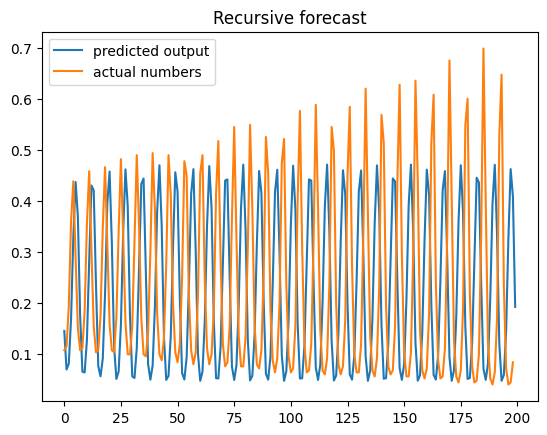

In [110]:
plt.title("Recursive forecast")
plt.plot(preds, label="predicted output")
plt.plot(testingExpectedOutputs.cpu(), label="actual numbers")
plt.legend()
plt.show()

# Training set comparison (old)

NameError: name 'outputs' is not defined

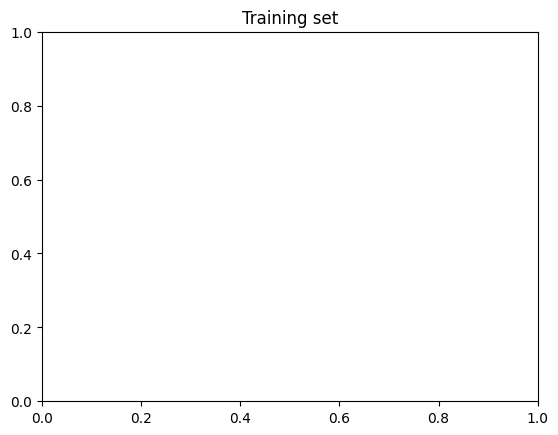

In [14]:
plt.title("Training set")
plt.plot(outputs.data.cpu(), label="predicted output")
plt.plot(trainingExpectedOutputs.cpu(), label="actual numbers")
plt.legend()

# Testing the model (old)

In [ ]:
testingOutputs = model(testingInputs)

print("MSE:", criterion(testingOutputs, testingExpectedOutputs).item())

plt.title("Testing set")
plt.plot(testingOutputs.data.cpu(), label="predicted output")
plt.plot(testingExpectedOutputs.cpu(), label="actual numbers")
plt.legend()
plt.show()

plt.plot(testingOutputs.data.cpu())
plt.show()

plt.plot(testingExpectedOutputs.cpu())
plt.show()